In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from statistics import mean,median,mode
#%matplotlib widget

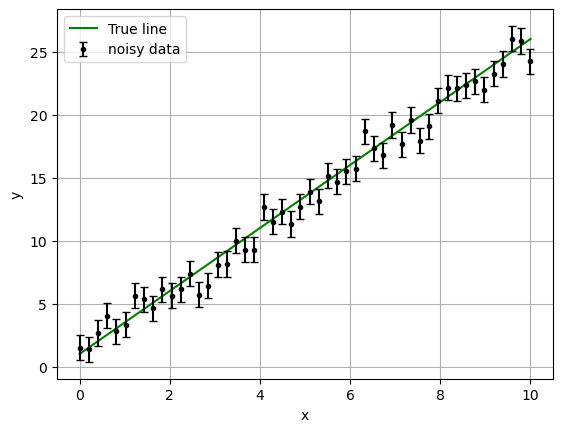

In [2]:
#Generating fake data
np.random.seed(42)
x = np.linspace(0,10,50)

#True line
m_true, c_true = 2.5,1
y_true = m_true*x + c_true

#synthetic data with random gaussian noise
y = y_true + np.random.normal(0,1,size = len(x))

#Plotting everything
plt.figure()
plt.plot(x,y_true,label='True line',color='green')
plt.errorbar(x,y,yerr=1.0,fmt = '.k',capsize = 3,label='noisy data')
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel('y')
plt.show()

In [3]:
#defining the model
def model(x,params):
    m,c = params
    return m*x + c

In [4]:
#Defining the likelihood
def log_likelihood(theta,x,y,yerr):
    #Here, x and y and err comes from the data
    return -0.5*np.sum(((y - model(x,theta))/yerr)**2)

In [5]:
#Defining the prior
def log_prior(params):
    #This function ensures that the parameters come from our desires range
    m,c = params
    if (0<m<5) and (-3<c<3):
        return 0
    return -np.inf # -infinity for unallowed values

In [6]:
# Define the posterior as a combination of likelihood and prior
def log_posterior(x,y,err,params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood(params,x,y,err) + log_prior(params)

In [7]:
# defining the proposal distribution, here proposal distribution is gaussian / normal
def proposal_density(current_params, proposal_params):
    current_m, current_c = current_params
    proposal_width_m, proposal_width_c = proposal_params

    proposed_m = np.random.normal(current_m, proposal_width_m)
    proposed_c = np.random.normal(current_c, proposal_width_c)

    return proposed_m, proposed_c

In [8]:
# The Metropolis-Algorithm MCMC
def metropolis_hastings(x,y,err,initial_params,proposal_params,n_iters):
    # Initial values
    current_m,current_c = initial_params
    trace_params = [[current_m],[current_c]]
    

    for i in range(n_iters):

        # Propose new values from current_values based on the proposal density
        current_params = current_m,current_c
        proposed_params = proposal_density(current_params,proposal_params)

        # Calculate log-posterior for current and proposed values
        current_log_posterior = log_posterior(x,y,err, current_params)
        proposed_log_posterior = log_posterior(x,y,err, proposed_params)

        # Acceptance ratio (The metropolis acceptance ratio)
        acceptance_ratio = np.exp(proposed_log_posterior - current_log_posterior)

        # Accept or reject the new state
        u = np.random.rand()
        if u < acceptance_ratio:
            current_m = proposed_params[0]
            current_c = proposed_params[1]

        # Append the current values to the trace
        trace_params[0].append(current_m)
        trace_params[1].append(current_c)

    return np.array(trace_params)

In [9]:
# Run MCMC
n_iters = 100000
initial_params = 1,1  #mu,sigma
proposal_params = 0.005,0.005 #mu,sigma for proposal
err=1 #added gaussian noise with with maximum value 1 so that is our error

trace_params = metropolis_hastings(x,y,err,initial_params,proposal_params,n_iters)

In [ ]:
# trace_params[0][1000:]

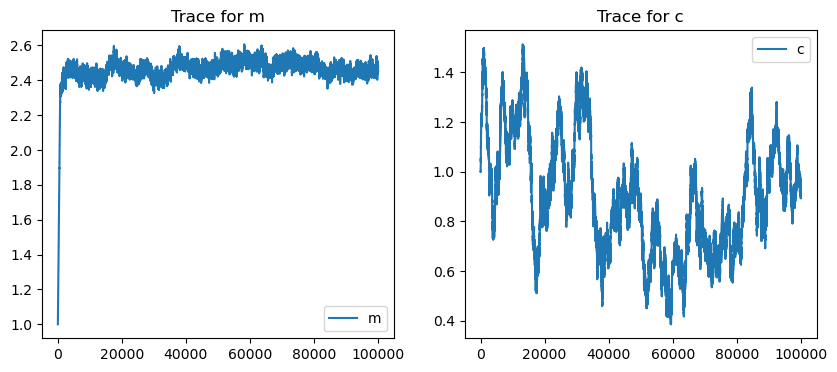

In [11]:
# Plot the traces for mu and sigma
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(trace_params[0], label='m')
plt.title("Trace for m")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trace_params[1], label='c')
plt.title("Trace for c")
plt.legend()

plt.show()

In [16]:
N = 10000 #Numbers of samples to be discarded as burn-in
print("m",mode(trace_params[0][N::]))
print("c",mode(trace_params[1][N::]))

m 2.506289922894367
c 0.9665764401480066


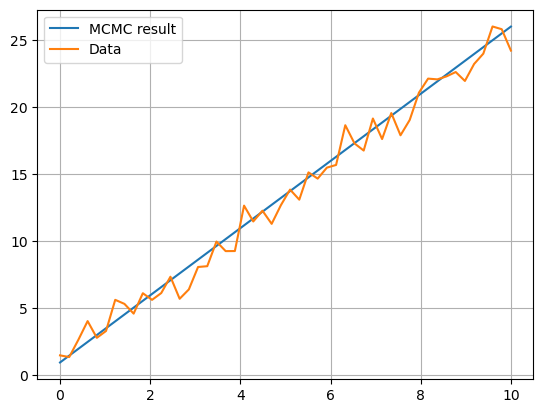

In [17]:
params = mode(trace_params[0][N::]),mode(trace_params[1][N::]) #discarded first 1000 samples which were part of the burn-in period
mcmc_data = model(x,params)

plt.figure()
plt.plot(x,mcmc_data,label='MCMC result')
plt.plot(x,y,label='Data')

plt.legend()
plt.grid()
plt.show()

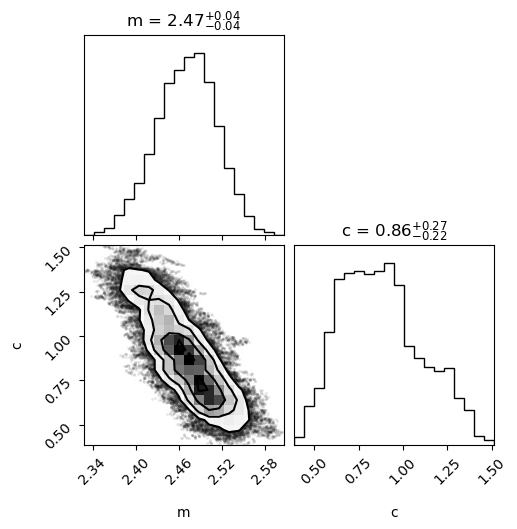

In [18]:
N = 10000 #No of samples to be discarded as burn-in period
samples_without_burn_in = np.array([trace_params[0][N:],trace_params[1][N:]])

# range_values = [(min(samples_without_burn_in[0]) - 0.5, max(samples_without_burn_in[0]) + 0.5),
#                 (min(samples_without_burn_in[1]) - 0.5, max(samples_without_burn_in[1]) + 0.5)]

labels = ['m','c']
#fig = corner.corner(samples_without_burn_in.T,show_titles=True,labels=labels,plot_datapoints=True,range=range_values)
fig = corner.corner(samples_without_burn_in.T,show_titles=True,labels=labels,plot_datapoints=True)